# 2D Convolution Example

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os

from kernel_viz import put_kernels_on_grid

%matplotlib inline
from IPython.core.pylabtools import figsize

In [2]:
tf.__version__

'1.5.0'

## Load the dataset

Let's do something *not* MNIST for a change.

The recommended way of getting images into TensorFlow is to create a TFrecord file- they're not the easiest format to work with though. With the new `tf.data` API, though, it's pretty easy to create a flexible input pipeline to pull images from disk.

We want our input pipeline to:

* load images and labels into a queue
* shuffle them
* parse the image data
* maybe do some augmentation
* put them into batches
* **prefetch the batches**

### Write a function that loads images and converts to common range and size

In [34]:
def parse_function(filename, label, size=100):
    # load the file and interpret the raw data as a JPG
    image_string = tf.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    # convert to float values between 0 and 1
    image = tf.image.convert_image_dtype(image, tf.float32)
    # resize and return
    resized = tf.image.resize_images(image, [size,size])
    return resized, label

### Add some random noise

In [168]:
def augment(im, label):
    im = tf.image.random_flip_left_right(im)
    im = tf.image.random_brightness(im, max_delta=0.35)
    im = tf.image.random_saturation(im, lower=0.75, upper=1.25)
    im = tf.clip_by_value(im, 0.0, 1.0)
    return im, label

### Build lists of all the locations of all the images (train and test sets, plus labels)

In [169]:
train0 = "images/0/"
train1 = "images/1/"
test0 = "images/test/0/"
test1 = "images/test/1/"

trainfiles = [train0+x for x in os.listdir(train0)] + [train1+x for x in os.listdir(train1)]
trainlabels = [0]*len(os.listdir(train0)) + [1]*len(os.listdir(train1))

testfiles = [test0+x for x in os.listdir(test0)] + [test1+x for x in os.listdir(test1)]
testlabels = [0]*len(os.listdir(test0)) + [1]*len(os.listdir(test1))

### Use `tf.data.Dataset` to build input pipelines

One for training, one for testing.

In [178]:
def training_input_dataset(epochs=10):
    ds = tf.data.Dataset.from_tensor_slices((trainfiles, trainlabels))
    ds = ds.repeat(epochs)
    ds = ds.shuffle(epochs*len(trainfiles))
    ds = ds.map(parse_function)
    ds = ds.map(augment, num_parallel_calls=4)
    ds = ds.batch(25)
    ds = ds.prefetch(1)
    return ds

In [179]:
def test_input_dataset(epochs=1):
    ds = tf.data.Dataset.from_tensor_slices((testfiles, testlabels))
    #ds = ds.repeat(epochs)
    ds = ds.map(parse_function)
    ds = ds.batch(len(testfiles))
    ds = ds.prefetch(1)
    return ds

In [180]:
x, y = training_input_dataset().make_one_shot_iterator().get_next()

In [181]:
x

<tf.Tensor 'IteratorGetNext_2:0' shape=(?, 100, 100, 3) dtype=float32>

In [182]:
y

<tf.Tensor 'IteratorGetNext_2:1' shape=(?,) dtype=int32>

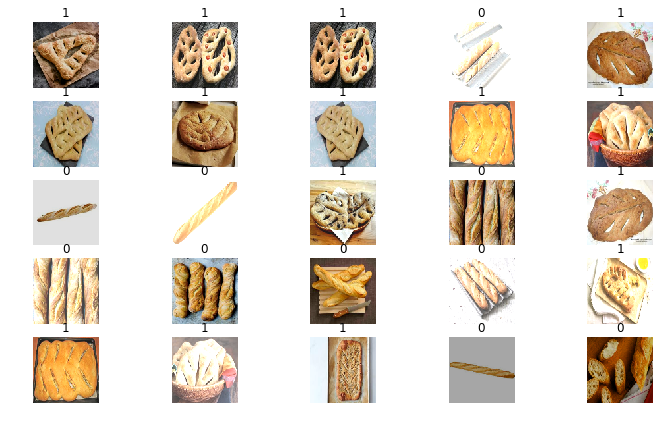

In [185]:
figsize(12, 7)
with tf.Session() as sess:
    im, lab = sess.run([x,y])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(im[i,:,:,:])
        plt.title(lab[i])
        plt.axis("off")

In [191]:
tf.reset_default_graph()

epochs=1000

train_ds = training_input_dataset()
test_ds = test_input_dataset()
data_iterator = tf.data.Iterator.from_structure(train_ds.output_types, 
                                               train_ds.output_shapes)
img, y_ = data_iterator.get_next()
training_init_op = data_iterator.make_initializer(train_ds)
test_init_op = data_iterator.make_initializer(test_ds)

#img, y_ = training_inputs(epochs)
#testim, testy_ = test_inputs(epochs)

y_oh = tf.one_hot(y_, 2)

print("img:", img.get_shape())

net = tf.layers.conv2d(img, 24, [9, 9], padding="same", activation=tf.nn.relu)
#net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same")
net = tf.layers.max_pooling2d(net, pool_size=8, strides=8, padding="same")
print("pool1:", net.get_shape())

viz = put_kernels_on_grid([x for x in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
             if "kernel" in x.name][0])
print("viz:", viz.get_shape())

for i, k in enumerate([16]):
    net = tf.layers.conv2d(net, k, [3, 3], padding="same", activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, pool_size=8, strides=8, padding="same")
    #net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same")
    print("pool %s"%(i+1), net.get_shape())



flat = tf.layers.flatten(net)
print("flat:", flat.get_shape())

logits = tf.layers.dense(flat, 2)
probs = tf.nn.softmax(logits)
predictions = tf.argmax(logits, 1, output_type=tf.int32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, y_), tf.float32))

loss = tf.losses.softmax_cross_entropy(y_oh, logits)
learn_rate = tf.train.exponential_decay(1e-3, global_step=tf.train.get_or_create_global_step(), 
                                        decay_steps=500, decay_rate=0.5)
optimizer = tf.train.RMSPropOptimizer(learn_rate)
train_op = optimizer.minimize(loss)

img: (?, 100, 100, 3)
pool1: (?, 13, 13, 24)
grid: 24 = (4, 6)
viz: (1, 44, 66, 3)
pool 1 (?, 2, 2, 16)
flat: (?, 64)


test accuracy: 0.5
0 test accuracy: 0.5
test accuracy: 0.8181818
100 test accuracy: 0.8181818
test accuracy: 0.77272725
200 test accuracy: 0.77272725
test accuracy: 0.8636364
300 test accuracy: 0.8636364
test accuracy: 0.8636364
400 test accuracy: 0.8636364
test accuracy: 0.8181818
500 test accuracy: 0.8181818
test accuracy: 0.8181818
600 test accuracy: 0.8181818
test accuracy: 0.8181818
700 test accuracy: 0.8181818
test accuracy: 0.8636364
800 test accuracy: 0.8636364
test accuracy: 0.8636364
900 test accuracy: 0.8636364
test accuracy: 0.8181818
1000 test accuracy: 0.8181818
test accuracy: 0.8636364
1100 test accuracy: 0.8636364
test accuracy: 0.8636364
1200 test accuracy: 0.8636364
test accuracy: 0.8636364
1300 test accuracy: 0.8636364
test accuracy: 0.8636364
1400 test accuracy: 0.8636364
test accuracy: 0.77272725
1500 test accuracy: 0.77272725
test accuracy: 0.6818182
1600 test accuracy: 0.6818182
test accuracy: 0.8636364
1700 test accuracy: 0.8636364
test accuracy: 0.8636364
1800 

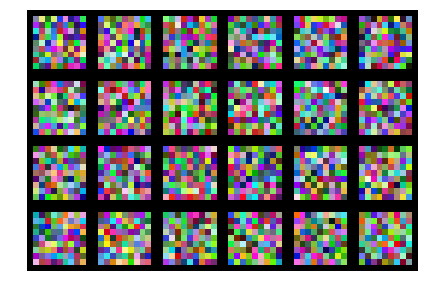

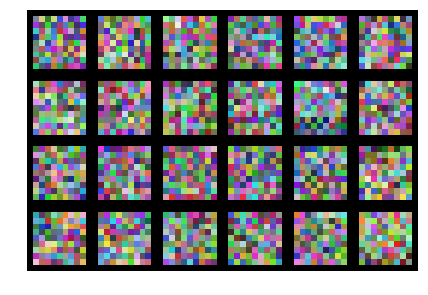

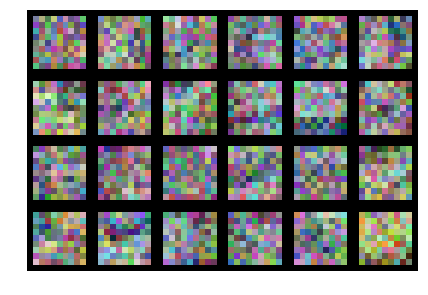

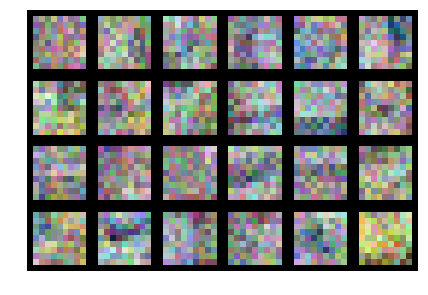

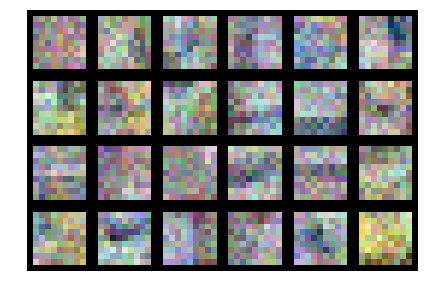

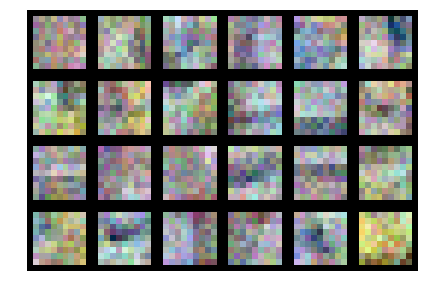

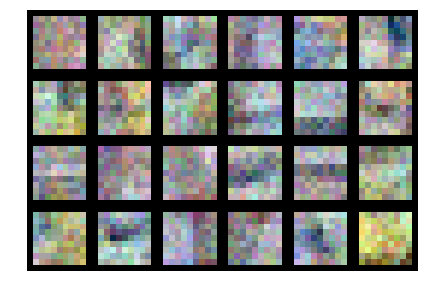

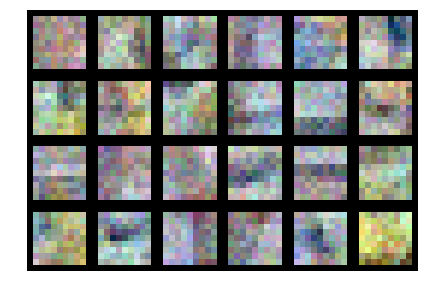

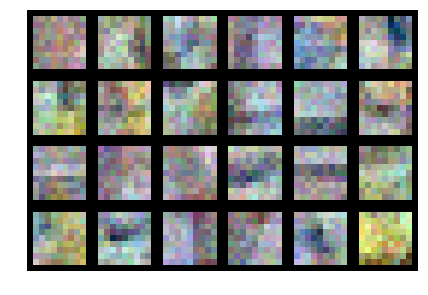

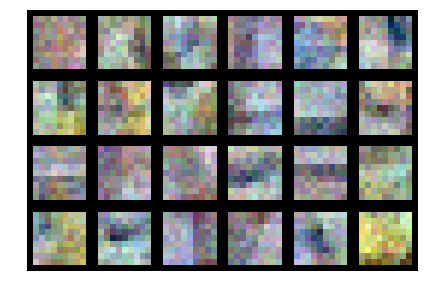

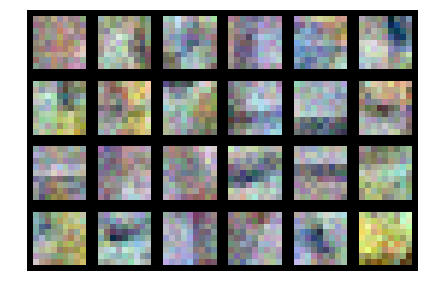

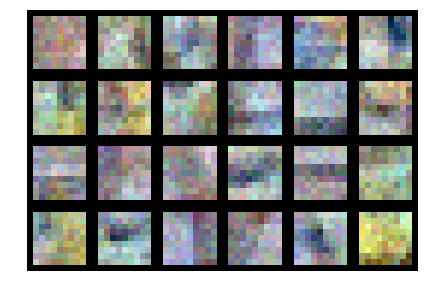

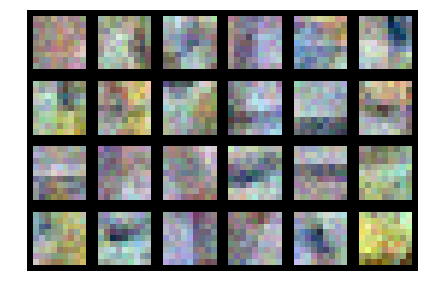

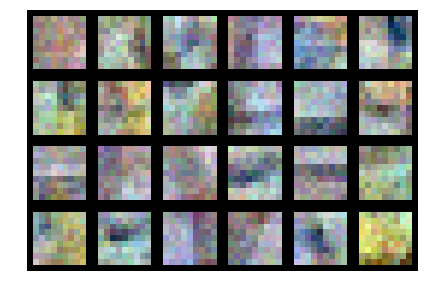

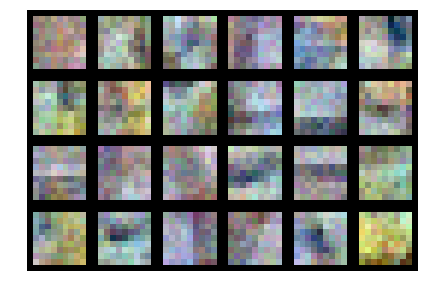

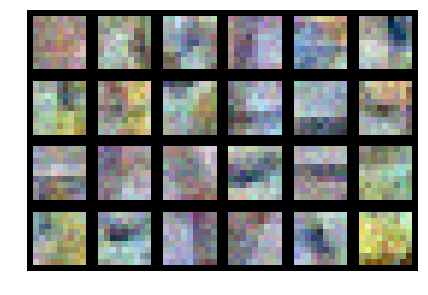

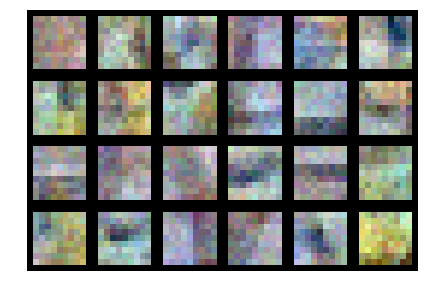

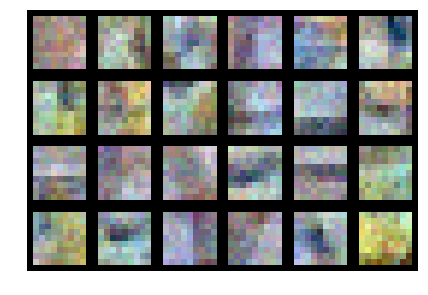

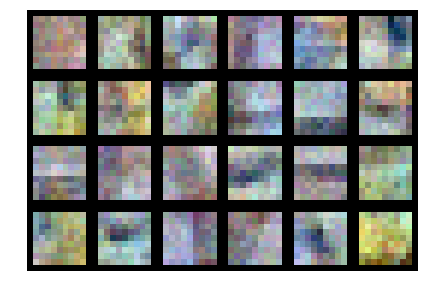

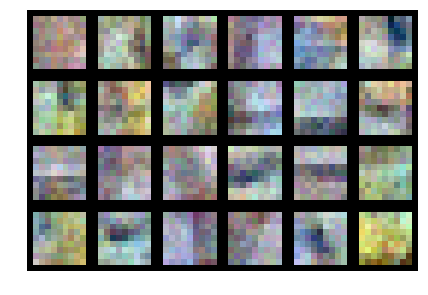

In [192]:
figsize(7,5)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(2000):
        sess.run(training_init_op)
        #im, lab = mnist.train.next_batch(250)
        sess.run(train_op)
        if e % 100 == 0:
            sess.run(test_init_op)
            acc = sess.run(accuracy)
            print("test accuracy: %s"%acc)
            print("%s test accuracy: %s"%(e,acc))
            plt.figure()
            plt.imshow(sess.run(viz)[0,:,:,:], interpolation="none")
            plt.axis("off")
